In [1]:
from santa_fe_2 import *
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from numba import njit
from scipy.optimize import curve_fit
import pandas as pd


@njit()
def compute_price_impact(price,sign,max_lag,step=1):
    impact = []
    for i in range(1,max_lag,step):
        impact.append((-sign[:-i]*(price[i:]-price[:-i])).mean())
    
    return impact

@njit()
def compute_diffusion_rate(vol_size,array, min_val = 1):
    variance = np.zeros(vol_size - min_val + 1)
    for i in range(min_val, vol_size+1):
        new_arr = array[i:]-array[:-i]
        variance[i - min_val] = new_arr.var()
    return variance

@njit()
def compute_volatility(vol_size,array):
    sigma = np.zeros(vol_size)
    for i in range(1,vol_size+1):
        #new_arr = ((array[i:]-array[:-i])**2).mean()
        #sigma[i] = np.sqrt((new_arr/array.mean()**2))
        sigma[i] = array[::i].std()
    return sigma

@njit()
def compute_volatility_1(vol_size,array):
    sigma = np.zeros(vol_size)
    for i in range(1,vol_size+1):
        new_arr = (array[i:]-array[:-i])**2
        sigma[i] = new_arr.sum()/i
    return sigma

def avg(lst):
    return np.array(lst).mean()

def func(x, m, q):
    return m * x + q

def find_param(xx,yy):
    popt, pcov = curve_fit(func, xx, yy)
    m = popt[0]
    q = popt[1]
    err_m = np.sqrt(pcov[0][0])
    err_q = np.sqrt(pcov[1][1])

    
    return m, q, err_m, err_q

def func(x,x0,gamma):
    return x0*x+gamma

def func2(x,x0,gamma):
    return x0*x**gamma

def find_param_vol(xx,yy,x0=10e-5,gamma=1):
    popt, pcov = curve_fit(func2, xx, yy,p0=(x0,gamma))
    xx0 = popt[0]
    gamma0 = popt[1]
    return xx0,gamma0

@njit()
def compute_price_impact(price,sign,max_lag,step=1):
    impact = []
    for i in range(1,max_lag,step):
        impact.append((sign[:-i]*(price[i:]-price[:-i])).mean())
    
    return impact

# Spread 

In [2]:
_, _, spread, lamb, nu, mu, _, _, volat, gts = \
    np.loadtxt("santa_fe_parameter_estimation_2.txt",delimiter=",", unpack = True)

In [3]:
mean_sp = np.zeros(len(spread))
vol = np.zeros(len(spread))
gap_to_spr = np.zeros(len(spread))

i = 0
for limit, market, cancel in zip(lamb, nu, mu):
    lob, _, _, _  = simulate_lob(limit, market, cancel, 1000, 500_000)
    md, sp = find_mid_spread_lob(lob)
    mean_sp[i] = sp.mean()
    vol[i] = md.std()
    gap_to_spr[i] = find_gap(lob)/sp.mean()
    i += 1 

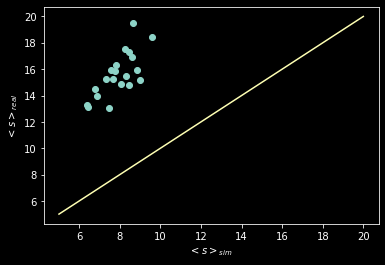

In [4]:
plt.style.use('dark_background')
xx = np.linspace(5,20,100)
plt.plot(mean_sp,spread,"o")
plt.xlabel(r"$<s>_{sim}$")
plt.ylabel(r"$<s>_{real}$")
plt.plot(xx,xx)


In [5]:
#create a list of all the files in the folder
DIR ="C:\\Users\\spina\\Documents\\SOLDI\\data\\tesla_2015\\order\\TSLA_2015-01-30_34200000_57600000_orderbook_10.csv"
header_list = ["ask price","ask vol","bid price","bid vol"]

df_order = pd.concat([pd.read_csv(DIR, names=header_list,usecols=[0,1,2,3])])
df_order.reset_index(drop=True, inplace=True)

df_order["ask price"] = df_order["ask price"]/100
df_order["bid price"] = df_order["bid price"]/100
# add spread and mid price to the dataframe
df_order["spread"] = df_order["ask price"] - df_order["bid price"]
df_order["mid price"] = (df_order["ask price"] + df_order["bid price"]) / 2

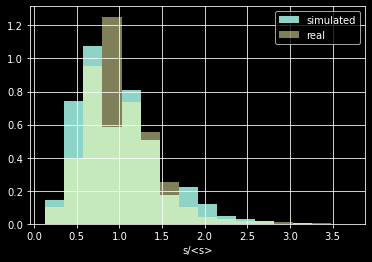

In [17]:

    n,n_bins,_ = plt.hist(sp/mean_sp[-1], density=True,bins=16, label = "simulated")
      
    plt.xlabel("s/<s>")

    (df_order["spread"] / df_order["spread"].mean()).hist(bins = n_bins, density=True, alpha=0.5, label="real")
    plt.legend()
    plt.show()

# gap to spread

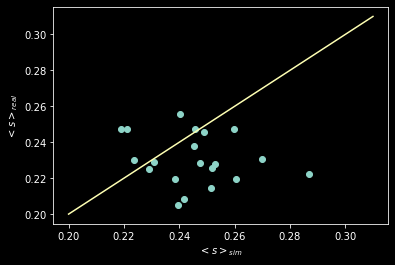

In [7]:
plt.plot(gap_to_spr,gts,"o")
plt.xlabel(r"$<s>_{sim}$")
plt.ylabel(r"$<s>_{real}$")
x = np.linspace(.20,.31,20)

plt.plot(x,x)

# volatility

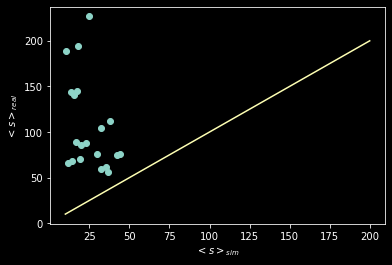

In [8]:
plt.plot(vol,volat,"o")
x1 = np.linspace(10,200,10)
plt.xlabel(r"$<s>_{sim}$")
plt.ylabel(r"$<s>_{real}$")
plt.plot(x1,x1)